In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import glob
import cv2
import os 
from keras import Sequential
from keras import layers
from keras import optimizers
from keras.layers import Flatten,Dense,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from keras.optimizers import Adam,RMSprop
from keras.losses import BinaryCrossentropy
from keras.applications import ResNet50V2, VGG19
from keras.callbacks import EarlyStopping
from keras import models
from keras.layers import Dropout, Flatten, Dense 
from keras.optimizers import SGD,Adam
from keras.models import load_model
from keras.utils import to_categorical 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, recall_score
import math 

import tools.visualizations as vis
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the generators 

In [3]:
train_path = "data/split2/train/"
test_path = "data/split2/test/"
val_path = "data/split2/val/"

In [4]:
imgs_bacteria = [file for file in os.listdir(train_path+'BACTERIA') if file.endswith('.jpeg')]
len(imgs_bacteria)

1668

In [5]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_path, target_size=(64, 64), batch_size = 3514, class_mode='categorical') 

Found 3514 images belonging to 3 classes.


In [6]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_path, 
        target_size=(64, 64), 
        batch_size = 1171,
        class_mode='categorical') 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_path, 
        target_size=(64, 64),
        batch_size = 1171,
        class_mode='categorical')


Found 1171 images belonging to 3 classes.
Found 1171 images belonging to 3 classes.


In [7]:
print(train_generator.class_indices)

{'BACTERIA': 0, 'NORMAL': 1, 'VIRUS': 2}


In [8]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [9]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 3514
Number of testing samples: 1171
Number of validation samples: 1171
train_images shape: (3514, 64, 64, 3)
train_labels shape: (3514, 3)
test_images shape: (1171, 64, 64, 3)
test_labels shape: (1171, 3)
val_images shape: (1171, 64, 64, 3)
val_labels shape: (1171, 3)


In [10]:
#train_classes = train_generator.classes 
num_classes_train = len(train_generator.class_indices) 
#train_labels_cat = to_categorical(train_classes, num_classes=num_classes_train)

# Base Model

In [11]:
np.random.seed(123)
model1 = models.Sequential()
model1.add(Flatten(input_shape=train_images.shape[1:])) 
model1.add(layers.Dense(20, activation='relu'))
model1.add(layers.Dense(7, activation='relu'))
model1.add(layers.Dense(5, activation='relu'))
model1.add(layers.Dense(num_classes_train, activation='softmax'))

model1.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['acc'])


In [12]:
history1 = model1.fit(train_images, train_labels, 
   epochs=10,
   batch_size=32, 
   validation_data=(val_images,val_labels))

Epoch 1/10
110/110 [==============================] - 1s 6ms/step - loss: 1.0718 - acc: 0.4600 - val_loss: 1.0355 - val_acc: 0.4748
Epoch 2/10
110/110 [==============================] - 0s 3ms/step - loss: 1.0198 - acc: 0.4871 - val_loss: 0.9676 - val_acc: 0.4774
Epoch 3/10
110/110 [==============================] - 0s 3ms/step - loss: 0.9443 - acc: 0.5384 - val_loss: 0.8157 - val_acc: 0.6738
Epoch 4/10
110/110 [==============================] - 0s 3ms/step - loss: 0.8377 - acc: 0.6251 - val_loss: 0.7141 - val_acc: 0.6755
Epoch 5/10
110/110 [==============================] - 0s 3ms/step - loss: 0.8033 - acc: 0.6352 - val_loss: 0.8559 - val_acc: 0.6311
Epoch 6/10
110/110 [==============================] - 0s 3ms/step - loss: 0.7561 - acc: 0.6593 - val_loss: 0.6637 - val_acc: 0.7037
Epoch 7/10
110/110 [==============================] - 0s 3ms/step - loss: 0.6770 - acc: 0.6903 - val_loss: 0.6665 - val_acc: 0.7020
Epoch 8/10
110/110 [==============================] - 0s 3ms/step - loss: 0.

In [13]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 20)                245780    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 18        
Total params: 245,985
Trainable params: 245,985
Non-trainable params: 0
_________________________________________________________________


### Evaluation 

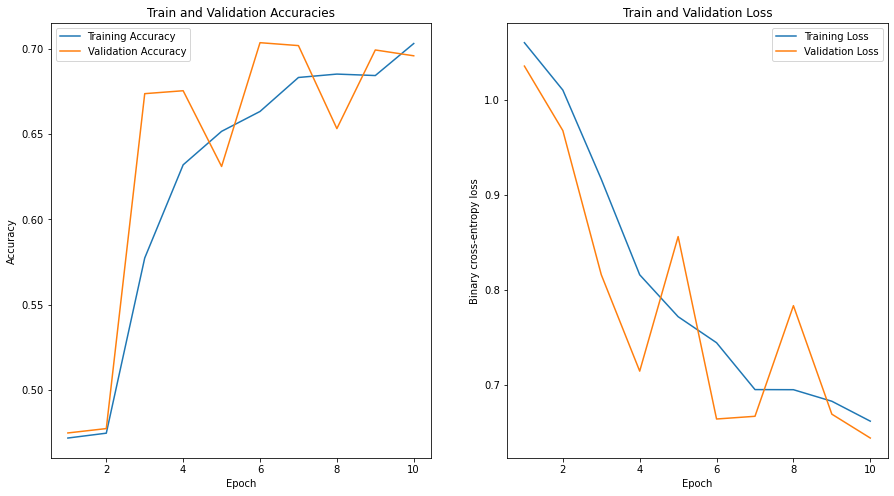

In [14]:
vis.plot_loss_accuracy(history1)
plt.savefig('images/Multi/base_neural_model1.png')
plt.show()

# Neural Network 2

In [15]:
np.random.seed(123)
model2 = Sequential() 
model2.add(layers.Flatten(input_shape=(64, 64, 3)))
model2.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model2.add(Dropout(0.5)) 
model2.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model2.add(Dropout(0.3)) 
model2.add(Dense(num_classes_train, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=(['acc'],tf.keras.metrics.FalseNegatives()))

In [16]:
history2 = model2.fit(train_images, train_labels, 
   epochs=10,
   batch_size=32, 
   validation_data=(val_images , val_labels))

Epoch 1/10
110/110 [==============================] - 1s 9ms/step - loss: 1.3500 - acc: 0.4480 - false_negatives: 1146.0721 - val_loss: 0.7473 - val_acc: 0.7105 - val_false_negatives: 528.0000
Epoch 2/10
110/110 [==============================] - 1s 8ms/step - loss: 0.9386 - acc: 0.5785 - false_negatives: 874.3874 - val_loss: 0.8261 - val_acc: 0.6046 - val_false_negatives: 631.0000
Epoch 3/10
110/110 [==============================] - 1s 8ms/step - loss: 0.8939 - acc: 0.6057 - false_negatives: 803.2883 - val_loss: 1.0064 - val_acc: 0.6063 - val_false_negatives: 486.0000
Epoch 4/10
110/110 [==============================] - 1s 8ms/step - loss: 0.8584 - acc: 0.6410 - false_negatives: 724.5676 - val_loss: 0.8577 - val_acc: 0.6063 - val_false_negatives: 491.0000
Epoch 5/10
110/110 [==============================] - 1s 8ms/step - loss: 0.8117 - acc: 0.6489 - false_negatives: 713.7658 - val_loss: 0.6229 - val_acc: 0.7532 - val_false_negatives: 394.0000
Epoch 6/10
110/110 [===================

### Evaluation 

In [17]:
model2.evaluate( 
    test_images , test_labels, batch_size=50, verbose=1)

24/24 [==============================] - 0s 4ms/step - loss: 0.5754 - acc: 0.7541 - false_negatives: 350.0000


[0.5754366517066956, 0.7540563344955444, 350.0]

In [18]:
y_hat_test2 = model2.predict(test_images) 

In [19]:
categorical_test_labels = pd.DataFrame(test_labels,columns= ('BACTERIA', 'NORMAL', 'VIRUS')).idxmax(axis=1)
categorical_preds2 = pd.DataFrame(y_hat_test2,columns= ('BACTERIA', 'NORMAL', 'VIRUS')).idxmax(axis=1)

<AxesSubplot:>

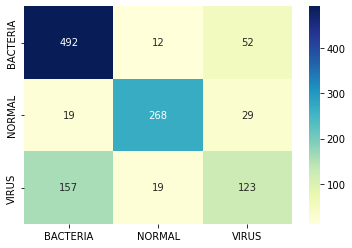

In [20]:
cnf_matrix = confusion_matrix(categorical_test_labels,categorical_preds2,labels=['BACTERIA', 'NORMAL' ,'VIRUS'] )
sns.heatmap(cnf_matrix , annot=True, fmt="d",cmap="YlGnBu",xticklabels=['BACTERIA', 'NORMAL' ,'VIRUS'], yticklabels=['BACTERIA', 'NORMAL' ,'VIRUS'])

In [21]:
classification_metrics= classification_report(categorical_test_labels,categorical_preds2, target_names=['BACTERIA', 'NORMAL' ,'VIRUS'])
print(classification_metrics)

              precision    recall  f1-score   support

    BACTERIA       0.74      0.88      0.80       556
      NORMAL       0.90      0.85      0.87       316
       VIRUS       0.60      0.41      0.49       299

    accuracy                           0.75      1171
   macro avg       0.75      0.71      0.72      1171
weighted avg       0.75      0.75      0.74      1171



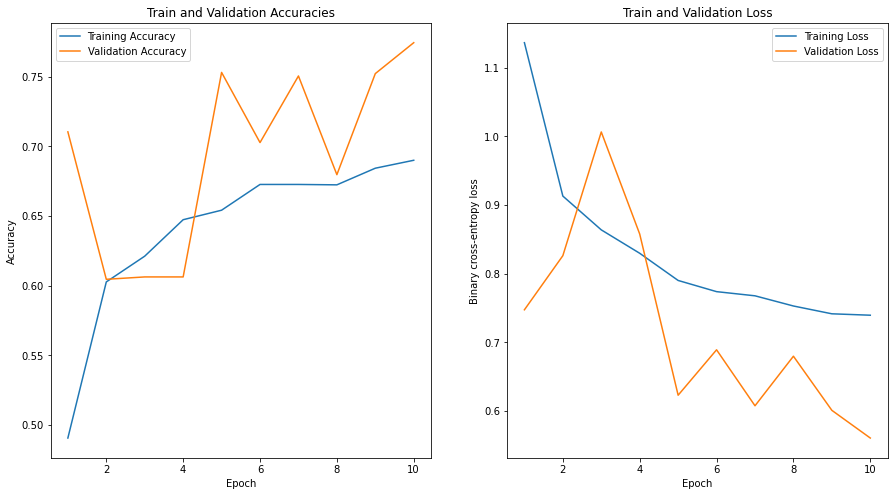

In [22]:
vis.plot_loss_accuracy(history2)
plt.savefig('images/Multi/neural_model2.png')
plt.show()

# CNN 1

In [23]:
np.random.seed(123)
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(num_classes_train, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer= 'sgd',
              metrics=['acc'])

In [24]:
history3 = model3.fit(train_images, train_labels, 
   epochs=10,
   batch_size=32, 
   validation_data=(val_images , val_labels))

Epoch 1/10
110/110 [==============================] - 7s 66ms/step - loss: 1.0694 - acc: 0.4219 - val_loss: 1.0147 - val_acc: 0.4757
Epoch 2/10
110/110 [==============================] - 7s 68ms/step - loss: 1.0046 - acc: 0.5227 - val_loss: 0.8972 - val_acc: 0.6712
Epoch 3/10
110/110 [==============================] - 7s 67ms/step - loss: 0.9065 - acc: 0.5973 - val_loss: 0.8405 - val_acc: 0.6285
Epoch 4/10
110/110 [==============================] - 7s 66ms/step - loss: 0.7690 - acc: 0.6698 - val_loss: 0.7044 - val_acc: 0.6994
Epoch 5/10
110/110 [==============================] - 7s 65ms/step - loss: 0.7048 - acc: 0.6920 - val_loss: 0.6314 - val_acc: 0.7182
Epoch 6/10
110/110 [==============================] - 7s 65ms/step - loss: 0.6545 - acc: 0.7199 - val_loss: 0.6148 - val_acc: 0.7472
Epoch 7/10
110/110 [==============================] - 7s 65ms/step - loss: 0.6139 - acc: 0.7377 - val_loss: 0.6172 - val_acc: 0.7336
Epoch 8/10
110/110 [==============================] - 7s 65ms/step - 

### Evaluation 

In [25]:
model3.evaluate( 
    test_images , test_labels, batch_size=50, verbose=1)

24/24 [==============================] - 1s 26ms/step - loss: 0.6172 - acc: 0.7310


[0.6171630024909973, 0.7309991717338562]

In [26]:
y_hat_test3 = model3.predict(test_images) 

In [27]:
categorical_preds3 = pd.DataFrame(y_hat_test3,columns= ('BACTERIA', 'NORMAL', 'VIRUS')).idxmax(axis=1)

<AxesSubplot:>

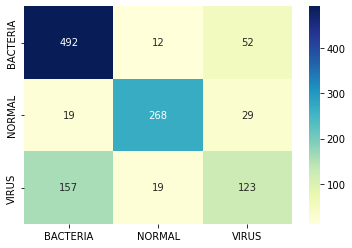

In [28]:
sns.heatmap(cnf_matrix , annot=True, fmt="d",cmap="YlGnBu",xticklabels=['BACTERIA', 'NORMAL' ,'VIRUS'], yticklabels=['BACTERIA', 'NORMAL' ,'VIRUS'])

In [29]:
classification_metrics= classification_report(categorical_test_labels,categorical_preds3, target_names=['BACTERIA', 'NORMAL' ,'VIRUS'])
print(classification_metrics)

              precision    recall  f1-score   support

    BACTERIA       0.75      0.84      0.79       556
      NORMAL       0.72      0.96      0.82       316
       VIRUS       0.66      0.29      0.40       299

    accuracy                           0.73      1171
   macro avg       0.71      0.70      0.67      1171
weighted avg       0.72      0.73      0.70      1171



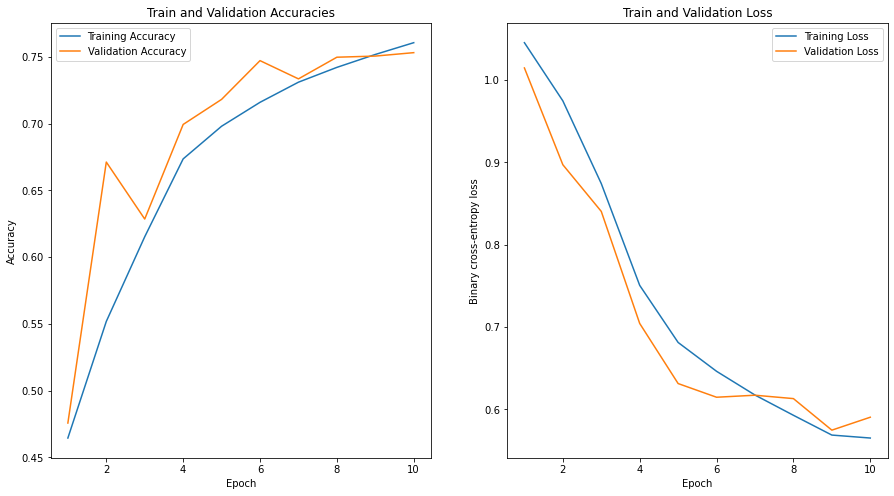

In [30]:
vis.plot_loss_accuracy(history3)
plt.savefig('images/Multi/cnn_model3.png')
plt.show()

# CNN 2

In [31]:
np.random.seed(123)
model4= models.Sequential()
model4.add(layers.Conv2D(filters=48, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
model4.add(layers.MaxPool2D(pool_size=2, strides=2))
model4.add(layers.Conv2D(filters=48, kernel_size=3, activation='relu'))
model4.add(layers.MaxPool2D(pool_size=2, strides=2))
model4.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model4.add(layers.MaxPool2D(pool_size=2, strides=2))
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation='relu'))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(3, activation='softmax'))

# finally compile and train the cnn
model4.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])

In [32]:
history4 = model4.fit(train_images, train_labels, 
   epochs=10,
   batch_size=32, 
   validation_data=(val_images , val_labels))

Epoch 1/10
110/110 [==============================] - 9s 82ms/step - loss: 0.9859 - acc: 0.5323 - val_loss: 0.6277 - val_acc: 0.7165
Epoch 2/10
110/110 [==============================] - 9s 78ms/step - loss: 0.5916 - acc: 0.7372 - val_loss: 0.5593 - val_acc: 0.7754
Epoch 3/10
110/110 [==============================] - 8s 76ms/step - loss: 0.5318 - acc: 0.7708 - val_loss: 0.5206 - val_acc: 0.7874
Epoch 4/10
110/110 [==============================] - 8s 77ms/step - loss: 0.4645 - acc: 0.7979 - val_loss: 0.5179 - val_acc: 0.7950
Epoch 5/10
110/110 [==============================] - 9s 77ms/step - loss: 0.4714 - acc: 0.7941 - val_loss: 0.5328 - val_acc: 0.7728
Epoch 6/10
110/110 [==============================] - 9s 78ms/step - loss: 0.4802 - acc: 0.7976 - val_loss: 0.5291 - val_acc: 0.7891
Epoch 7/10
110/110 [==============================] - 9s 78ms/step - loss: 0.4525 - acc: 0.7946 - val_loss: 0.5023 - val_acc: 0.7993
Epoch 8/10
110/110 [==============================] - 9s 78ms/step - 

### Evaluation 

In [33]:
model4.evaluate( 
    test_images , test_labels, batch_size=50, verbose=1)

24/24 [==============================] - 1s 31ms/step - loss: 0.5190 - acc: 0.7805


[0.5189955234527588, 0.7805294394493103]

In [36]:
y_hat_test4 = model4.predict(test_images ) 

In [37]:
categorical_preds4 = pd.DataFrame(y_hat_test4,columns= ('BACTERIA', 'NORMAL', 'VIRUS')).idxmax(axis=1)

<AxesSubplot:>

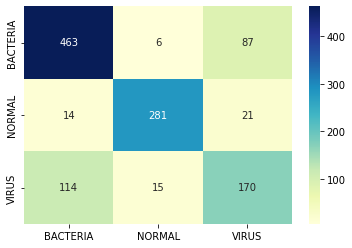

In [38]:
cnf_matrix = confusion_matrix(categorical_test_labels,categorical_preds4,labels=['BACTERIA', 'NORMAL' ,'VIRUS'] )
sns.heatmap(cnf_matrix , annot=True, fmt="d",cmap="YlGnBu",xticklabels=['BACTERIA', 'NORMAL' ,'VIRUS'], yticklabels=['BACTERIA', 'NORMAL' ,'VIRUS'])

In [39]:
classification_metrics= classification_report(categorical_test_labels,categorical_preds4, target_names=['BACTERIA', 'NORMAL' ,'VIRUS'])
print(classification_metrics)

              precision    recall  f1-score   support

    BACTERIA       0.78      0.83      0.81       556
      NORMAL       0.93      0.89      0.91       316
       VIRUS       0.61      0.57      0.59       299

    accuracy                           0.78      1171
   macro avg       0.78      0.76      0.77      1171
weighted avg       0.78      0.78      0.78      1171



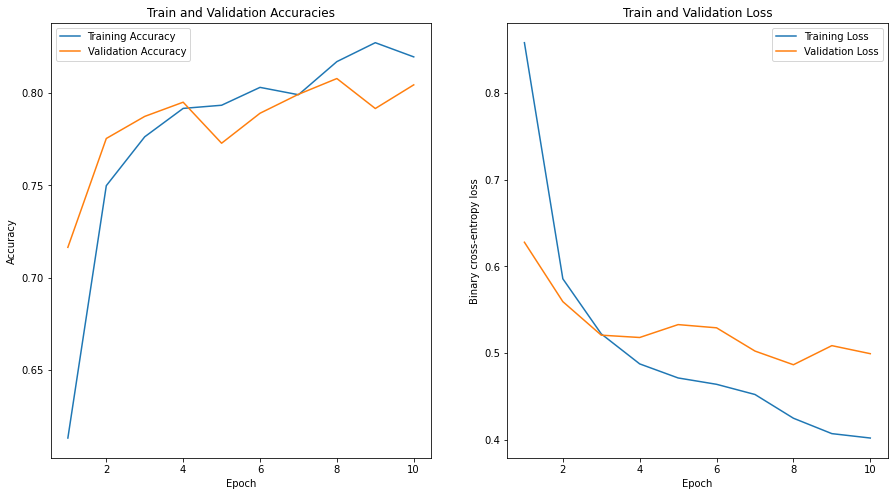

In [40]:
vis.plot_loss_accuracy(history4)
plt.savefig('images/Multi/cnn_model4.png')
plt.show()

# Trasnfer learning VGG19

In [41]:
np.random.seed(123)
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (64,64,3), classes = train_labels.shape[1])
model5= models.Sequential()
model5.add(base_model) 
model5.add(Flatten()) 
model5.add(Dense(1024,activation=('relu')))
model5.add(Dense(512,activation=('relu'))) 
model5.add(Dense(256,activation=('relu'))) 
model5.add(Dropout(.3))
model5.add(Dropout(.2))
model5.add(Dense(3,activation=('softmax'))) 

In [42]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [43]:
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model5.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['acc'])

In [44]:
base_model.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model5.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model5.trainable_weights))

vgg19 False
flatten_4 True
dense_12 True
dense_13 True
dense_14 True
dropout_2 True
dropout_3 True
dense_15 True
8


In [45]:
history5 = model5.fit(train_images, train_labels, 
   epochs=10,
   batch_size=32, 
   validation_data=(val_images , val_labels))

Epoch 1/10
110/110 [==============================] - 485s 4s/step - loss: 0.8745 - acc: 0.5812 - val_loss: 0.6547 - val_acc: 0.7122
Epoch 2/10
110/110 [==============================] - 491s 4s/step - loss: 0.5635 - acc: 0.7542 - val_loss: 0.6144 - val_acc: 0.7370
Epoch 3/10
110/110 [==============================] - 481s 4s/step - loss: 0.5016 - acc: 0.7969 - val_loss: 0.5945 - val_acc: 0.7686
Epoch 4/10
110/110 [==============================] - 482s 4s/step - loss: 0.4503 - acc: 0.8144 - val_loss: 0.4569 - val_acc: 0.8232
Epoch 5/10
110/110 [==============================] - 478s 4s/step - loss: 0.4055 - acc: 0.8349 - val_loss: 0.4600 - val_acc: 0.8113
Epoch 6/10
110/110 [==============================] - 461s 4s/step - loss: 0.4072 - acc: 0.8306 - val_loss: 0.4578 - val_acc: 0.8198
Epoch 7/10
110/110 [==============================] - 463s 4s/step - loss: 0.3626 - acc: 0.8528 - val_loss: 0.4495 - val_acc: 0.8173
Epoch 8/10
110/110 [==============================] - 465s 4s/step - 

### Evaluation 

In [46]:
model5.evaluate( 
    test_images , test_labels, batch_size=50, verbose=1)

24/24 [==============================] - 37s 2s/step - loss: 0.5406 - acc: 0.7874


[0.540552020072937, 0.787361204624176]

In [47]:
y_hat_test5= model5.predict(test_images) 

In [48]:
categorical_preds5 = pd.DataFrame(y_hat_test5,columns= ('BACTERIA', 'NORMAL', 'VIRUS')).idxmax(axis=1)

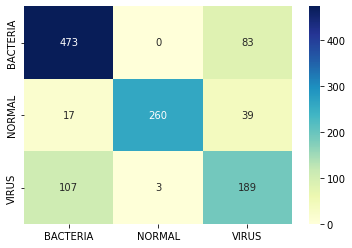

In [49]:
cnf_matrix = confusion_matrix(categorical_test_labels,categorical_preds5,labels=['BACTERIA', 'NORMAL' ,'VIRUS'] )
sns.heatmap(cnf_matrix , annot=True, fmt="d",cmap="YlGnBu",xticklabels=['BACTERIA', 'NORMAL' ,'VIRUS'], yticklabels=['BACTERIA', 'NORMAL' ,'VIRUS'])
plt.savefig('images/Multi/confusion.png')

In [50]:
classification_metrics= classification_report(categorical_test_labels,categorical_preds3, target_names=['BACTERIA', 'NORMAL' ,'VIRUS'])
print(classification_metrics)

              precision    recall  f1-score   support

    BACTERIA       0.75      0.84      0.79       556
      NORMAL       0.72      0.96      0.82       316
       VIRUS       0.66      0.29      0.40       299

    accuracy                           0.73      1171
   macro avg       0.71      0.70      0.67      1171
weighted avg       0.72      0.73      0.70      1171



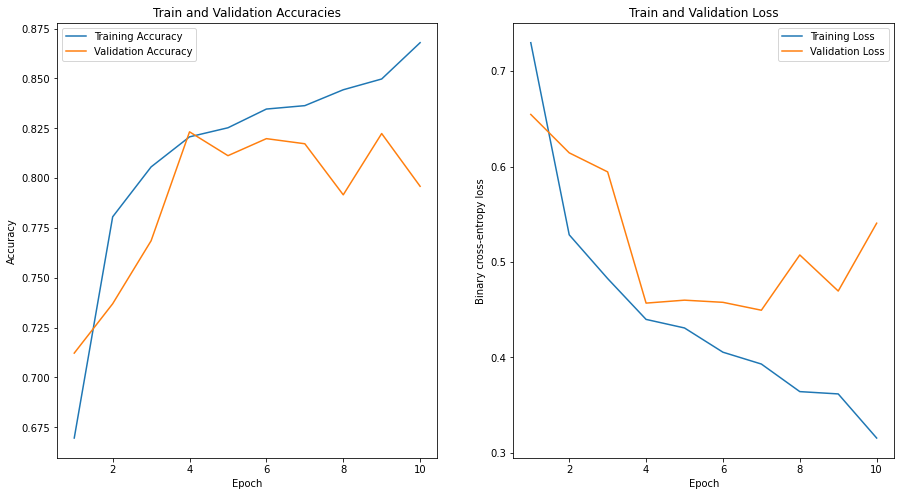

In [51]:
vis.plot_loss_accuracy(history5)
plt.savefig('images/Multi/transfer_model5.png')
plt.show()

# Recall score bar chart

In [52]:
names = [
    'Model 1',
    'Model 2',
    'Model 3',
    'Model 4',
    'Model 5'
]

models = [
    model1,
    model2,
    model3,
    model4,
    model5
]

histories = [
    history1.history,
    history2.history,
    history3.history,
    history4.history,
    history5.history
]

In [53]:
accs = [hist['acc'][-1] for hist in histories]
val_accs = [hist['val_acc'][-1] for hist in histories]
test_accs = [model.evaluate(test_images, test_labels)[1] for model in models]

37/37 [==============================] - 36s 983ms/step - loss: 0.5406 - acc: 0.7874


In [55]:
recs = []
val_recs = []
test_recs = []
for model in models:
    train_preds = (model.predict(train_images) > 0.5).astype('int32')
    val_preds = (model.predict(val_images) > 0.5).astype('int32')
    test_preds = (model.predict(test_images) > 0.5).astype('int32')

    rec = recall_score(train_labels, train_preds,average="weighted")
    val_rec = recall_score(val_labels, val_preds,average="weighted")
    test_rec = recall_score(test_labels, test_preds,average="weighted")

    recs.append(recall_score(train_labels, train_preds, average="weighted"))
    val_recs.append(recall_score(val_labels, val_preds, average="weighted"))
    test_recs.append(recall_score(test_labels, test_preds, average="weighted"))

In [63]:

# Create DataFrame for easier plotting
acc_data = {
    'Model': names,
    'Training Accuracy': accs,
    'Validation Accuracy': val_accs,
    'Testing Accuracy': test_accs,
}
rec_data = {
    'Model': names,
    'Training Recall': recs,
    'Validation Recall': val_recs,
    'Testing Recall': test_recs
}
acc_df = pd.DataFrame(acc_data)
rec_df = pd.DataFrame(rec_data)

rec_df['Testing Recall']=rec_df['Testing Recall'].map(lambda x: x*100)

display(acc_df, rec_df)

,Model,Training Accuracy,Validation Accuracy,Testing Accuracy
0,Model 1,0.703187,0.695986,0.707088
1,Model 2,0.690097,0.774552,0.754056
2,Model 3,0.760672,0.753202,0.730999
3,Model 4,0.819579,0.804441,0.780529
4,Model 5,0.867957,0.795901,0.787361


,Model,Training Recall,Validation Recall,Testing Recall
0,Model 1,0.633751,0.623399,62.169086
1,Model 2,0.717985,0.714774,70.111016
2,Model 3,0.694935,0.701110,67.378309
3,Model 4,0.834092,0.785653,77.711358
4,Model 5,0.857712,0.794193,78.223740


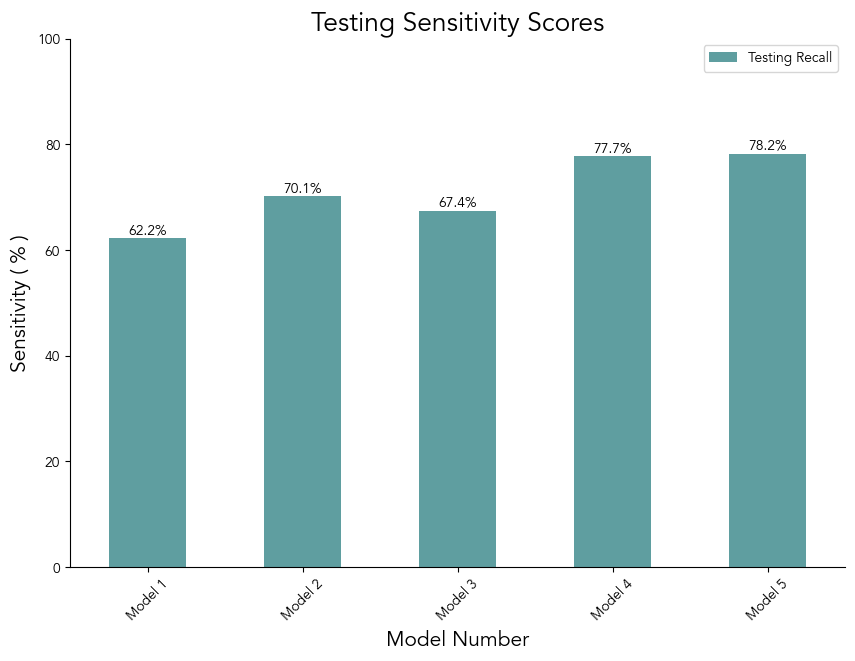

In [67]:
with plt.style.context('images/presentation.mplstyle'):
    ax =rec_df.set_index('Model').plot.bar(y='Testing Recall', color='cadetblue')
    plt.xticks(rotation=45)
    plt.title('Testing Sensitivity Scores')
    plt.xlabel('Model Number')
    plt.ylabel('Sensitivity ( % )')
    ymin=0
    ymax=1
    plt.ylim(ymin * 100, ymax * 100)
    
    rects = ax.patches
    labels = [f'{test_rec:.1%}' for test_rec in test_recs]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        plt.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    

    plt.savefig('images/Multi/recall.png')
    plt.show();

# Conclusion

It is expected to have a lower accuracy score with the multi-class models since the difference between viral and bacterial pneumonia is not nearly as distinqushable, even thought the imbalancement with the data set is lessen by splitting three ways. There are still a lot that can be done to tune the models for further improvement, such as implimenting different regularizations and optimzations. Also, the models can improve drastically if we were to enlarge the target image size; however, that would also increase the runtime.  